In [ ]:
!pip install requests beautifulsoup4 pandas matplotlib seaborn wordcloud



 SAMPLE DATA
                          Location         Price Rooms  Bathrooms  Car Parks         Property Type                      Size        Furnishing
0               KLCC, Kuala Lumpur  RM 1,250,000   2+1        3.0        2.0    Serviced Residence  Built-up : 1,335 sq. ft.   Fully Furnished
1  Damansara Heights, Kuala Lumpur  RM 6,800,000     6        7.0        NaN              Bungalow  Land area : 6900 sq. ft.  Partly Furnished
2            Dutamas, Kuala Lumpur  RM 1,030,000     3        4.0        2.0  Condominium (Corner)  Built-up : 1,875 sq. ft.  Partly Furnished
3             Cheras, Kuala Lumpur           NaN   NaN        NaN        NaN                   NaN                       NaN               NaN
4        Bukit Jalil, Kuala Lumpur    RM 900,000   4+1        3.0        2.0  Condominium (Corner)  Built-up : 1,513 sq. ft.  Partly Furnished

📊 Running Generic Dataset Analysis...
 BASIC DATASET STATISTICS (Generic)
Total rows: 28547
Total columns: 8
                 c

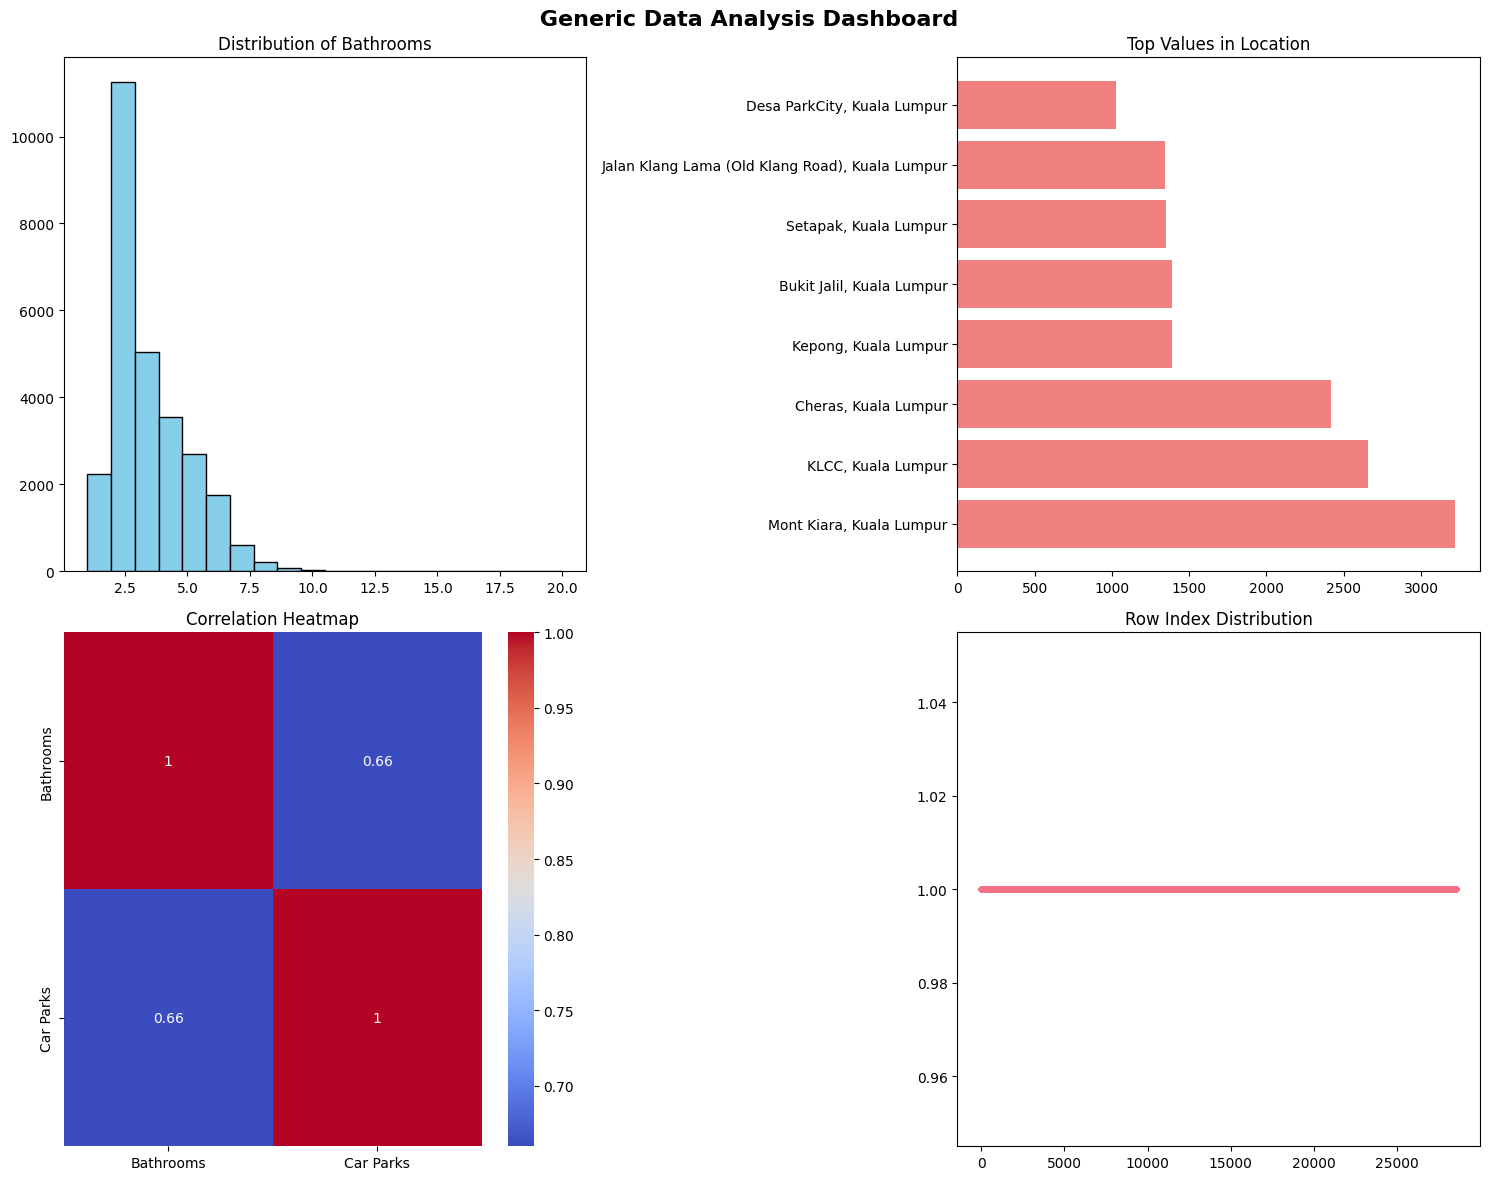

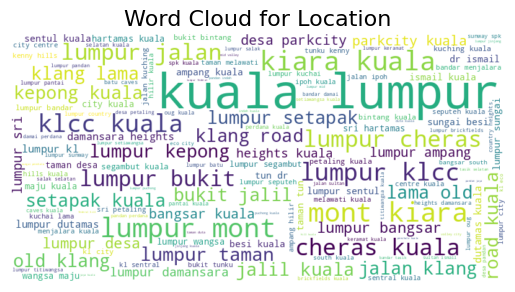


✅ Dataset saved as 'processed_dataset.csv'


In [3]:
#WEB SCRAPING project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import os
import csv

plt.style.use('default')
sns.set_palette("husl")

# -------- SET YOUR DATASET PATH HERE --------
dataset_path = "/content/data_kaggle.csv"  # Change this to your file path

# ---------------- QUOTE ANALYZER ----------------
class QuoteAnalyzer:
    def __init__(self, df):
        self.df = df
        if 'word_count' not in self.df.columns and 'quote' in self.df.columns:
            self.df['word_count'] = self.df['quote'].astype(str).apply(lambda x: len(x.split()))

    def basic_stats(self):
        print(" BASIC DATASET STATISTICS (Quotes)")
        print("=" * 50)
        print(f"Total quotes: {len(self.df)}")
        print(f"Unique authors: {self.df['author'].nunique()}")
        print(f"Average words per quote: {self.df['word_count'].mean():.1f}")
        print(f"Longest quote: {self.df['word_count'].max()} words")
        print(f"Shortest quote: {self.df['word_count'].min()} words")

    def analyze_authors(self):
        print("\n AUTHOR ANALYSIS")
        print("=" * 50)
        print(self.df['author'].value_counts().head(10))

    def analyze_tags(self):
        print("\n TAG ANALYSIS")
        print("=" * 50)
        if 'tags' not in self.df.columns:
            print("No tags column found.")
            return
        all_tags = [tag for tags_list in self.df['tags'] for tag in (tags_list if isinstance(tags_list, list) else str(tags_list).split(','))]
        print(Counter(all_tags).most_common(10))

    def create_visualizations(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(' Quote Data Analysis Dashboard', fontsize=16, fontweight='bold')

        axes[0, 0].hist(self.df['word_count'], bins=20, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Distribution of Quote Lengths')

        top_authors = self.df['author'].value_counts().head(8)
        axes[0, 1].barh(top_authors.index, top_authors.values, color='lightcoral')
        axes[0, 1].set_title('Top 8 Authors')

        if 'tags' in self.df.columns:
            all_tags = [tag for tags_list in self.df['tags'] for tag in (tags_list if isinstance(tags_list, list) else str(tags_list).split(','))]
            top_tags = Counter(all_tags).most_common(10)
            if top_tags:
                tag_names, tag_counts = zip(*top_tags)
                axes[1, 0].bar(tag_names, tag_counts, color='lightgreen')
                axes[1, 0].set_title('Top 10 Tags')
                axes[1, 0].tick_params(axis='x', rotation=45)
        else:
            axes[1, 0].text(0.5, 0.5, 'No tags column', ha='center')

        if 'page' in self.df.columns:
            page_counts = self.df['page'].value_counts().sort_index()
            axes[1, 1].plot(page_counts.index, page_counts.values, marker='o')
            axes[1, 1].set_title('Quotes by Page')
        else:
            axes[1, 1].text(0.5, 0.5, 'No page info', ha='center')

        plt.tight_layout()
        plt.show()

    def create_wordcloud(self):
        print("\n Generating Word Cloud...")
        all_text = ' '.join(self.df['quote'].astype(str).tolist())
        all_text = re.sub(r'[^\w\s]', '', all_text.lower())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of All Quotes', fontsize=16)
        plt.show()

# ---------------- GENERIC ANALYZER ----------------
class GenericAnalyzer:
    def __init__(self, df):
        self.df = df

    def basic_stats(self):
        print(" BASIC DATASET STATISTICS (Generic)")
        print("=" * 50)
        print(f"Total rows: {len(self.df)}")
        print(f"Total columns: {len(self.df.columns)}")
        print(self.df.describe(include='all').transpose())

    def create_visualizations(self):
        num_cols = self.df.select_dtypes(include=['number']).columns
        cat_cols = self.df.select_dtypes(include=['object']).columns

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(' Generic Data Analysis Dashboard', fontsize=16, fontweight='bold')

        if len(num_cols):
            axes[0, 0].hist(self.df[num_cols[0]].dropna(), bins=20, color='skyblue', edgecolor='black')
            axes[0, 0].set_title(f'Distribution of {num_cols[0]}')
        else:
            axes[0, 0].text(0.5, 0.5, 'No Numeric Data', ha='center')

        if len(cat_cols):
            top_counts = self.df[cat_cols[0]].value_counts().head(8)
            axes[0, 1].barh(top_counts.index, top_counts.values, color='lightcoral')
            axes[0, 1].set_title(f'Top Values in {cat_cols[0]}')
        else:
            axes[0, 1].text(0.5, 0.5, 'No Categorical Data', ha='center')

        if len(num_cols) > 1:
            sns.heatmap(self.df[num_cols].corr(), annot=True, cmap='coolwarm', ax=axes[1, 0])
            axes[1, 0].set_title('Correlation Heatmap')
        else:
            axes[1, 0].text(0.5, 0.5, 'Not Enough Numeric Data', ha='center')

        axes[1, 1].plot(range(len(self.df)), [1]*len(self.df), marker='o', markersize=3)
        axes[1, 1].set_title('Row Index Distribution')

        plt.tight_layout()
        plt.show()

    def create_wordcloud(self):
        text_cols = self.df.select_dtypes(include=['object']).columns
        if not len(text_cols):
            print("No text column for word cloud.")
            return
        all_text = ' '.join(self.df[text_cols[0]].dropna().astype(str).tolist())
        all_text = re.sub(r'[^\w\s]', '', all_text.lower())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {text_cols[0]}', fontsize=16)
        plt.show()

# ---------------- MAIN ----------------
def main():
    if not os.path.exists(dataset_path):
        print(f"❌ File not found at: {dataset_path}")
        return

    try:
        df = pd.read_csv(
            dataset_path,
            on_bad_lines='skip',  # Skips problematic rows
            engine='python',
            quoting=csv.QUOTE_MINIMAL
        )
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return

    print("\n SAMPLE DATA")
    print("=" * 50)
    print(df.head().to_string())

    # Detect dataset type
    if {'quote', 'author'}.issubset(df.columns):
        print("\n📜 Detected Quotes Dataset — Running QuoteAnalyzer...")
        analyzer = QuoteAnalyzer(df)
        analyzer.basic_stats()
        analyzer.analyze_authors()
        analyzer.analyze_tags()
        analyzer.create_visualizations()
        analyzer.create_wordcloud()
    else:
        print("\n📊 Running Generic Dataset Analysis...")
        analyzer = GenericAnalyzer(df)
        analyzer.basic_stats()
        analyzer.create_visualizations()
        analyzer.create_wordcloud()

    df.to_csv("processed_dataset.csv", index=False)
    print("\n✅ Dataset saved as 'processed_dataset.csv'")

if __name__ == "__main__":
    main()
